# mslicer, keeping record of the log-likelihoods

### D. Craig, on SciServer, 2019-09-12

In [1]:
using Plots
gr(fmt="png") #THIS IS NEEDED FOR SPEED in notebooks. SVG with many points is sloooowwww...

Plots.GRBackend()

## Version of mslicer which also returns log-likelihoods

Note that the following has the same name `mslicer` but returns a tuple `(xs, likelies)` where `xs` is the Markov chain and `likelies` is the record of log-likelihoods, including that of the initial guess.

In [2]:
function mslicer(g, dim, x0, xargs; N=1000, w=0.5, m=10)
    #=VERSION FOR VECTOR FIXES=#
    #= multi-D slice sampler, g: log of distribution function, 
    dim number of dimensions
    x0: start (or next) point, values of distribution parameters. x1: next point.
    xargs: extra arguments for distribution, Nm samples to return,
        w: "out step" distance, m: max number of outward steps.
    
    returns a tuple `(xs, likelies)` where `xs` is the Markov chain and 
    `likelies` is the record of log-likelihoods, including that of the initial guess.
    
    Note that you only have to worry about log scaling in 'vertical' comparisons
    in these Monte Carlo chain calculations.
    =#
    xs = zeros(N, dim)  # array that will be returned
    xs[1,:] = x0  #x0 should be array 1,dim; needs [1.0 1.0] syntax for this version.
    #print(x0)
    x1 = zeros(1,dim)
    L = zeros(1,dim)
    R = zeros(1,dim)
    likelies = zeros(N) # record log likelihoods
    likelies[1] = g(x0,xargs)  # get log-like of initial guess; avoid fencepost error
    way = zeros(1,dim)  # which axis to go along in space
    i = 2    # assumed start values for chain are recorded at xs[1,1]
    while i <= N
        for d in 1:dim       # go one step in each dimensional direction.
            way = 0.0 * way #clear it
            way[d] = 1.0 #set nonzero in direction we go for slicing on this step
            y0 = g(x0,xargs)  #height of distribution at x0
            y = y0 + log(rand()) # height for slice (using log scaled distribution)
            #start stepping out
            U = rand()   # between 0 and 1
            L = x0 - (w * way * U)
            R = L .+ w .* way
            
            V = rand()
            J = floor(m*V)
            K = (m - 1) - J
            while J > 0 && y < g(L,xargs)
                L = L .- w .* way
                J = J - 1
            end
            while K > 0 && y < g(R,xargs)
                R = R .+ w .* way
                K = K - 1
            end
            #now should be stepped out beyond distribution at slice level
            # work back in if no value found:
            Lbar, Rbar = L, R
            while true 
                U = rand()
                x1 = Lbar .+ U .* (Rbar .- Lbar)  # vector subtraction should be correct dir
                if y < g(x1,xargs)
                    break # exit while loop
                end
                if x1[d] < x0[d]
                    Lbar = x1
                    else 
                    Rbar = x1
                end
            end
            xs[i,:] = x1 # found an acceptable point, record in chain (a row)
            likelies[i] = y0 # record log-likelhood
            x0 = x1 # set initial to new point for next round.
            i += 1
            if i > N
                break # catch case where we reach N in the middle of set of dimensions
            end
        end # for d
        end  #while i
    return xs, likelies 
end

mslicer (generic function with 1 method)

In [3]:
# using LinearAlgebra # for dot function   #Not in Julia 0.6

### Make the fake data, a linear + noise model

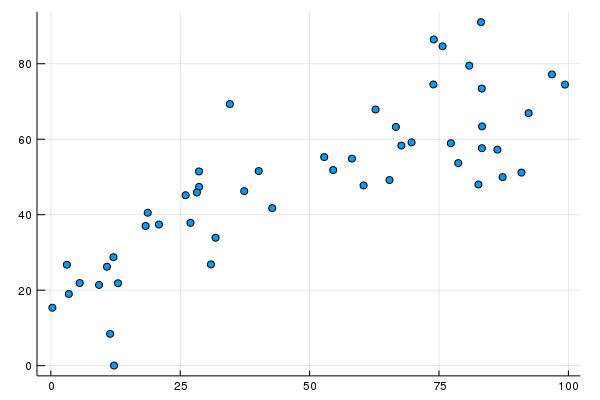

In [4]:
theta_true = [25.0 0.5] # [intercept slope]
xdata = 100*rand(50);
ydata = theta_true[1] .+ theta_true[2]*xdata
n = 10*randn(50)  # noise rms of 10
ydata += n
scatter(xdata, ydata, legend = false)

#### The following are log-prior and log-posterior models for the linear + noise fit:

In [5]:
function log_prior(theta)
    alpha, beta, sigma = theta
    if sigma < 0
        return -Inf   # log(0)
    else
        return -0.5 * log(1 + beta^2) - log(sigma)  #Jeffreys prior for slopes
    end
end

log_prior (generic function with 1 method)

In [6]:
log_prior([24 .4 5])

-1.683647914993237

In [7]:
function log_like(theta, xvec)
    alpha, beta, sigma = theta
    x = xvec[1]
    y = xvec[2]
    y_model = alpha .+ beta .* x
    return -0.5 * sum(log(2*pi*sigma^2) .+ (y - y_model).*(y - y_model) / sigma^2)
    #return y - y_model
end

log_like (generic function with 1 method)

In [8]:
function log_posterior(theta, xvec)
    return log_prior(theta) + log_like(theta,xvec)
end

log_posterior (generic function with 1 method)

In [9]:
print(log_posterior([25 .5 10], [xdata, ydata]))
#[xdata, ydata]

-198.7134060940869

## Execute; make the Markov chain:

In [10]:
res, likes = mslicer(log_posterior, 3, [30.0 0.6 10.0], [xdata, ydata], N=5000);

In [11]:
A_chain = res[:,1]
B_chain = res[:,2]
N_chain = res[:,3]; # get the MCMC parameter chains out with convenient names (marginalized samplings)

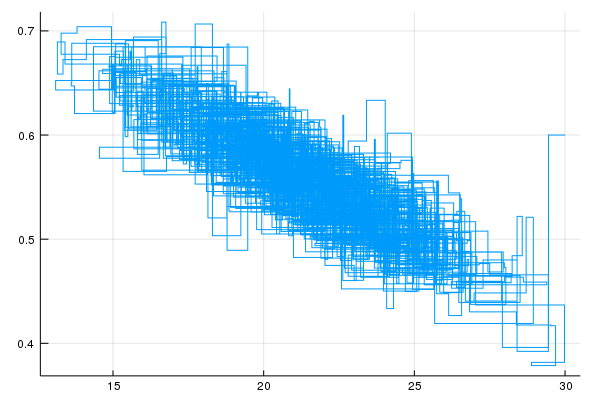

In [12]:
plot(A_chain,B_chain, legend=false)

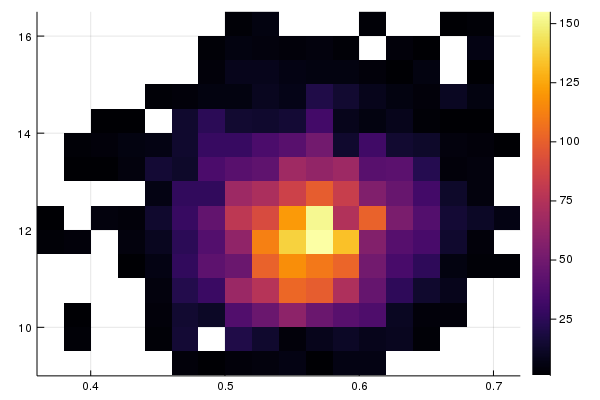

In [13]:
histogram2d(B_chain, N_chain)

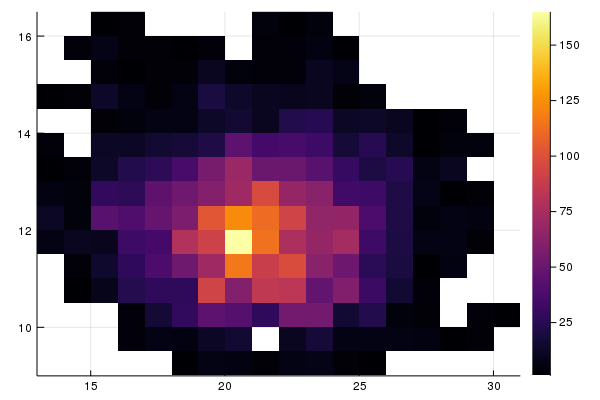

In [14]:
histogram2d(A_chain, N_chain)

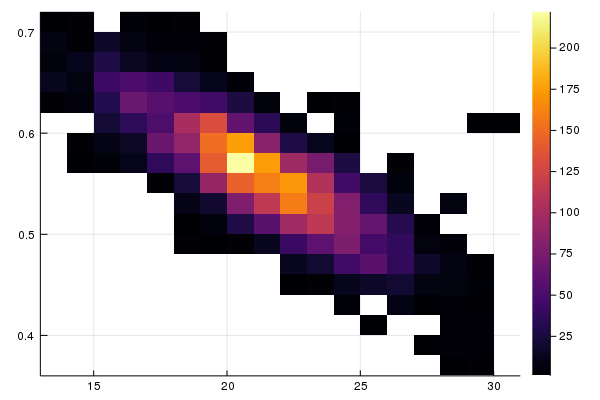

In [15]:
histogram2d(A_chain, B_chain)

In [16]:
maximum(likes)

-187.44831082755897

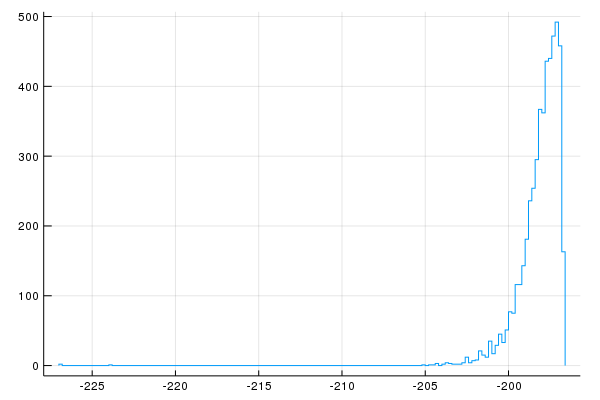

In [16]:
stephist(likes, legend=false)

In [17]:
indmax(likes)

3752

In [18]:
fit_idx = indmax(likes)

3752

In [19]:
A_fit = res[fit_idx,1]
B_fit = res[fit_idx,2]
N_fit = res[fit_idx,3];

In [20]:
A_fit, B_fit

(22.224930312350146, 0.5527035870804374)

In [21]:
N_fit

11.57674190527016

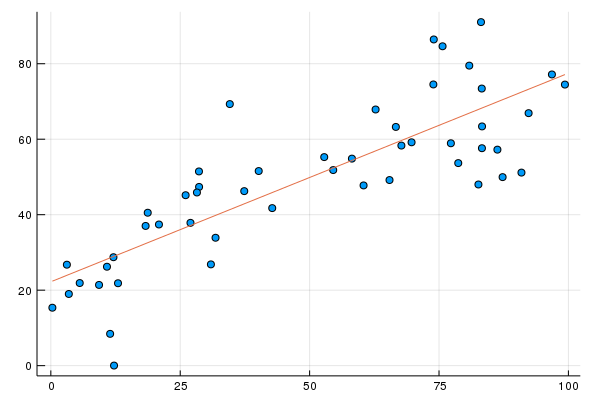

In [22]:
scatter(xdata, ydata, legend=false)  # original fake data
plot!(xdata, B_fit*xdata .+ A_fit)   # maximum likelihood model

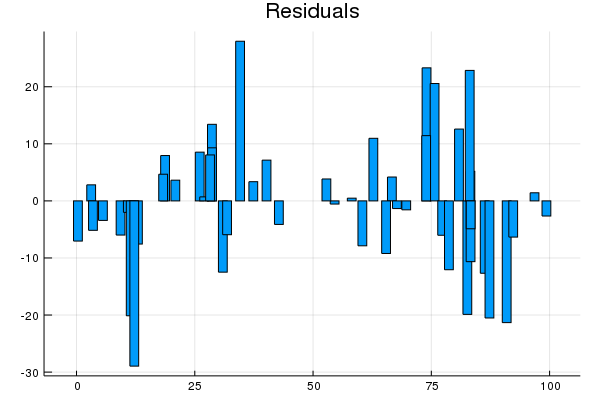

In [23]:
bar(xdata, ydata .- (B_fit*xdata .+ A_fit), legend=false, title="Residuals")

## Background: slice sampling

Slice sampling is a Markov Chain Monte Carlo technique that tries to cut down on the amount of tuning needed to get a sample from the asymptotic distribution. Here I will try to explain it to myself.

Suppose we have a distribution (or something proportional to one): $ p(x) $. We pick a point $ x_0.$ Then we find a $ y_0 = p(x_0)$

<img src="slice-sampling-fig1.png" width=50%/>

Next, pick a point using a uniform random number generator on the interval $[0,y_0]$: this gives us $y$, 
$y = \text{Uniform}[0, y_0]$. $y$ defines a 'height' at the point $x_0$ that is below the probablility density. This also defines a _slice_ across $p(x)$ at height $y$, I'll call it $\cal{S}$. Now $\cal S$ is an interval, but of course we _don't_ know where it ends at either high or low values of $x$ yet.

<img src="slice-sampling-fig2.png" width=50%/>

Pick a width $w$, and let $L = x_0 - w$ and $R = x_0 + w.$ Next, grow the width until $L$ and $R$ lie _outside_ $\cal S$.  This can be detected by when both $p(L)$ and $p(R)$ are both _less_ than $y$: $p(L) < y \text{ and } p(R) < y.$

There are various choices for growing $w$ to find the edges of the slice: muliplicative, additive, etc.

Next, find a point in $\cal S$ by picking a point $x_1$ (randomly) in $[L,R]$ such that $ y < p(x_1)$ :

- if you fail, just try again with a new random number, until you hit it.
- if you miss, you can (carefully) shrink the interval until you get an acceptable point.

The point $x_1$ that is accepted will be a sample from the distribution.

See: Neal, "Slice Sampling," _The Annals of Statistics_ 2003, vol. 31 (705-767). This is available online.

### Summary of Julia vector/matrix notation:

    [1 1 1] # 1x3 matrix
    [1 1 1]'# 3x1 matrix
    [1,1,1] # row vector
    
There is a useful page from stackoverflow: <https://stackoverflow.com/questions/21152051/difference-between-nx1-array-and-n-element-array-in-julia> on the array vs. vector notation in Julia.
